In [330]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import power_transform, MinMaxScaler, StandardScaler
import numpy as np

In [331]:
df = pd.read_csv('RV1_SIPIA.csv')

In [332]:
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10
0,2023-06-23 08:35:00+00:00,46.234818,15.267305,240.0,52.0,40.0,16.0,148.0
1,2023-09-17 07:35:00+00:00,46.234818,15.267305,240.0,11.0,118.0,7.0,135.0
2,2023-02-16 18:15:00+00:00,46.234818,15.267305,240.0,88.0,74.0,1.0,132.0
3,2023-02-16 18:35:00+00:00,46.234818,15.267305,240.0,88.0,74.0,1.0,132.0
4,2023-02-16 20:35:00+00:00,46.234818,15.267305,240.0,70.0,102.0,2.0,128.0


In [333]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

df.set_index('Date', inplace=True)

full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
missing_dates = full_date_range.difference(df.index)

print(missing_dates)

DatetimeIndex(['2023-03-17 19:35:00+00:00', '2023-03-18 19:35:00+00:00',
               '2023-03-19 19:35:00+00:00', '2023-03-20 19:35:00+00:00',
               '2023-03-21 19:35:00+00:00', '2023-03-22 19:35:00+00:00',
               '2023-03-23 19:35:00+00:00', '2023-03-24 19:35:00+00:00',
               '2023-03-25 19:35:00+00:00', '2023-03-26 19:35:00+00:00',
               '2023-03-27 19:35:00+00:00', '2023-03-28 19:35:00+00:00',
               '2023-03-29 19:35:00+00:00', '2023-03-30 19:35:00+00:00',
               '2023-03-31 19:35:00+00:00', '2023-04-01 19:35:00+00:00',
               '2023-04-02 19:35:00+00:00', '2023-04-03 19:35:00+00:00',
               '2023-04-04 19:35:00+00:00', '2023-04-05 19:35:00+00:00',
               '2023-04-06 19:35:00+00:00', '2023-04-07 19:35:00+00:00',
               '2023-04-08 19:35:00+00:00', '2023-04-09 19:35:00+00:00',
               '2023-04-10 19:35:00+00:00', '2023-04-11 19:35:00+00:00',
               '2023-04-12 19:35:00+00:00', '2023-0

In [334]:
df.isna().sum()

Latitude       0
Longitude      0
Altitude       0
NO2          402
PM2.5         67
O3           297
PM10          67
dtype: int64

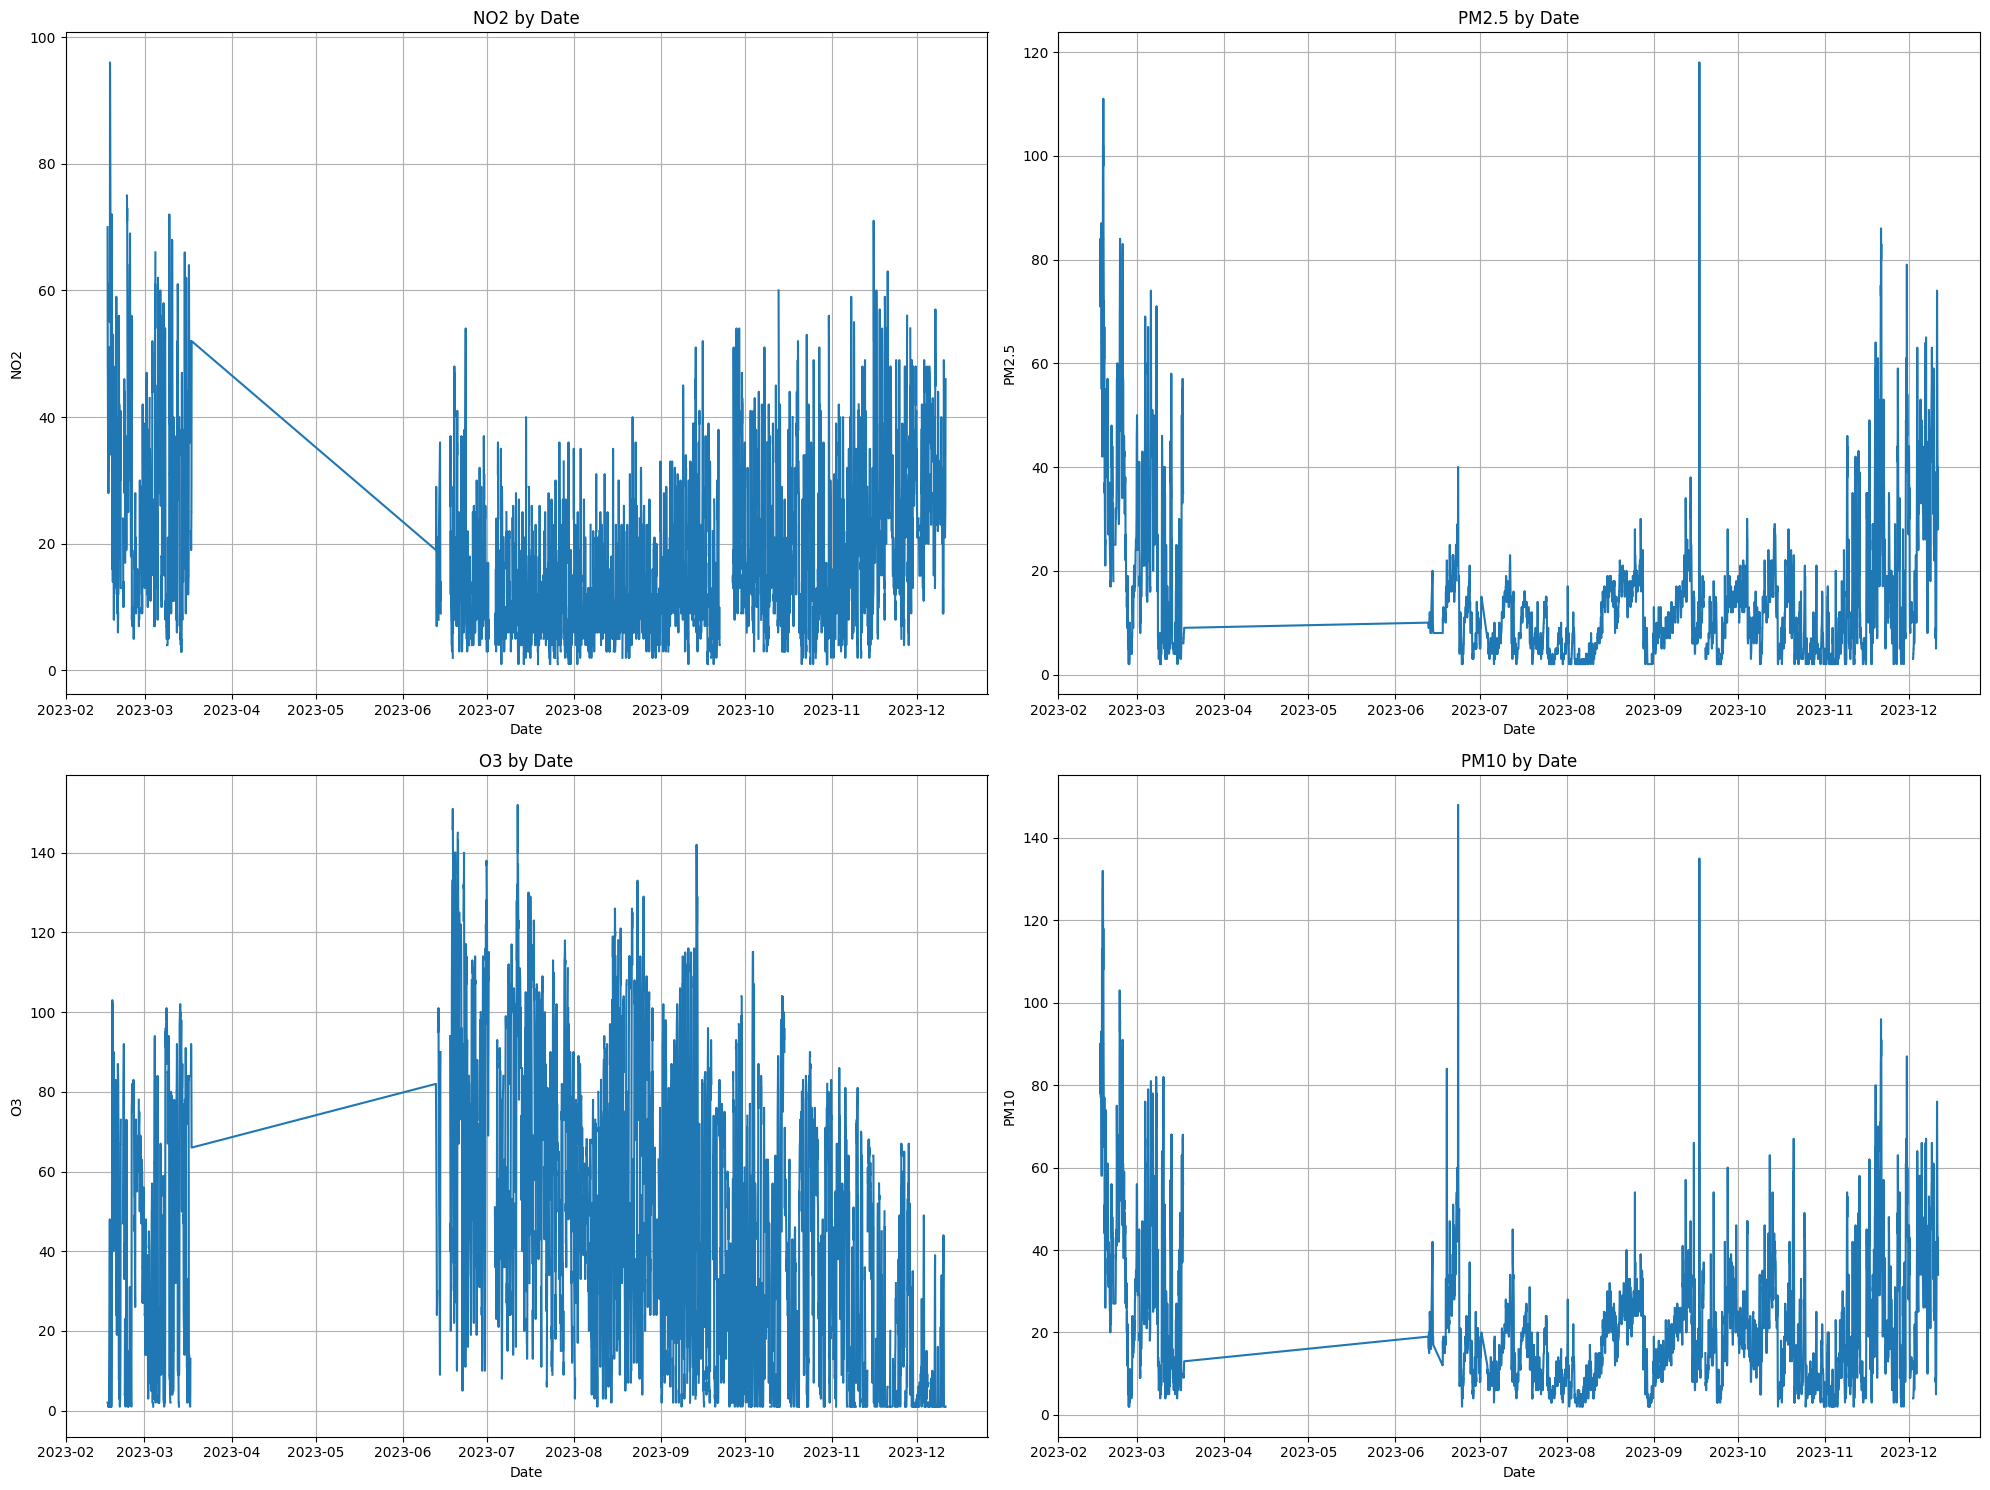

In [335]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 15))
axes = axes.flatten()
for i, column in enumerate(["NO2", "PM2.5", "O3", "PM10"]):
    axes[i].plot(df.index, df[column])
    axes[i].set_title(f'{column} by Date')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [336]:
df.describe()

,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10
count,5.625000e+03,5.625000e+03,5625.0,5223.000000,5558.000000,5328.000000,5558.000000
mean,4.623482e+01,1.526730e+01,240.0,19.042313,16.507377,44.400901,22.906441
std,7.106059e-15,3.553030e-15,0.0,13.622852,15.597033,34.448438,18.265637
min,4.623482e+01,1.526731e+01,240.0,1.000000,2.000000,1.000000,2.000000
25%,4.623482e+01,1.526731e+01,240.0,9.000000,6.000000,11.000000,10.000000
50%,4.623482e+01,1.526731e+01,240.0,15.000000,12.000000,41.000000,18.000000
75%,4.623482e+01,1.526731e+01,240.0,26.000000,20.000000,71.000000,30.000000
max,4.623482e+01,1.526731e+01,240.0,96.000000,118.000000,152.000000,148.000000


In [337]:
df.drop(['Latitude', 'Longitude', 'Altitude'], axis=1, inplace=True)

In [338]:
# TODO: Improve filling missing values
# for column in df.columns:
#     if df[column].isna().any():
#         df[column] = df[column].fillna(df[column].mean())
columns_with_missing_values = ['NO2', 'PM2.5', 'O3', 'PM10']

# Initialize SimpleImputer to fill missing feature values with the mean of the column
feature_imputer = SimpleImputer(strategy='mean')

# Iterate over each column with missing values and use RandomForestRegressor to impute
for column in columns_with_missing_values:
    # Prepare the feature dataset (exclude current target column)
    X = df.drop(columns=[column])
    
    # Impute missing feature values
    X_imputed = feature_imputer.fit_transform(X)
    
    # Prepare the target dataset
    y = df[column]
    
    # Split the data into training set (where target is not NaN) and prediction set (where target is NaN)
    X_train = X_imputed[y.notna()]
    y_train = y[y.notna()]
    X_pred = X_imputed[y.isna()]
    
    # Initialize the RandomForestRegressor
    rfr = RandomForestRegressor(n_estimators=100, random_state=0)

    # Train the model
    rfr.fit(X_train, y_train)
    
    # Predict the missing values
    predicted_values = rfr.predict(X_pred)
    
    # Fill in the missing values in the DataFrame
    df.loc[df[column].isna(), column] = predicted_values

# Save the imputed dataframe if needed
# df.to_csv('imputed_data.csv', index=False)

In [339]:
df.isna().sum()

NO2      0
PM2.5    0
O3       0
PM10     0
dtype: int64

In [340]:
def plot_distributions(df, ncols=4):
    columns = df.columns
    ncols = ncols
    nrows = (len(columns) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 4))

    if nrows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for i, column in enumerate(columns):
        ax = axes[i]
        ax.hist(df[column].dropna(), bins=20, alpha=0.7, color='blue', edgecolor='black')
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

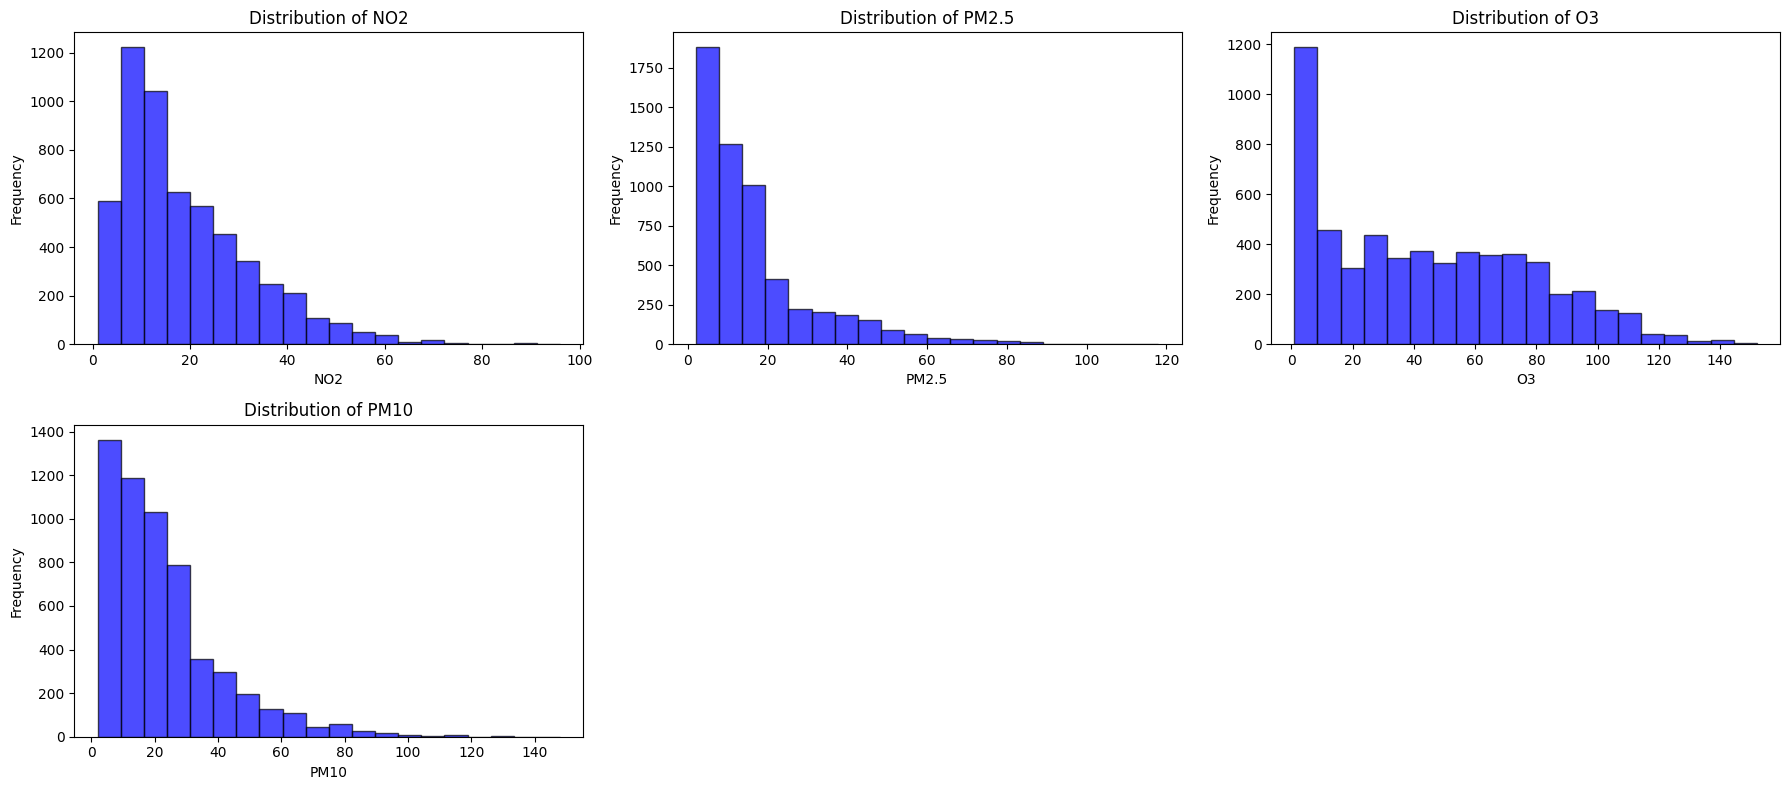

In [341]:
plot_distributions(df=df, ncols=3)

In [342]:
for column in df.columns:
    df[column] = power_transform(df[[column]].values, method='yeo-johnson')

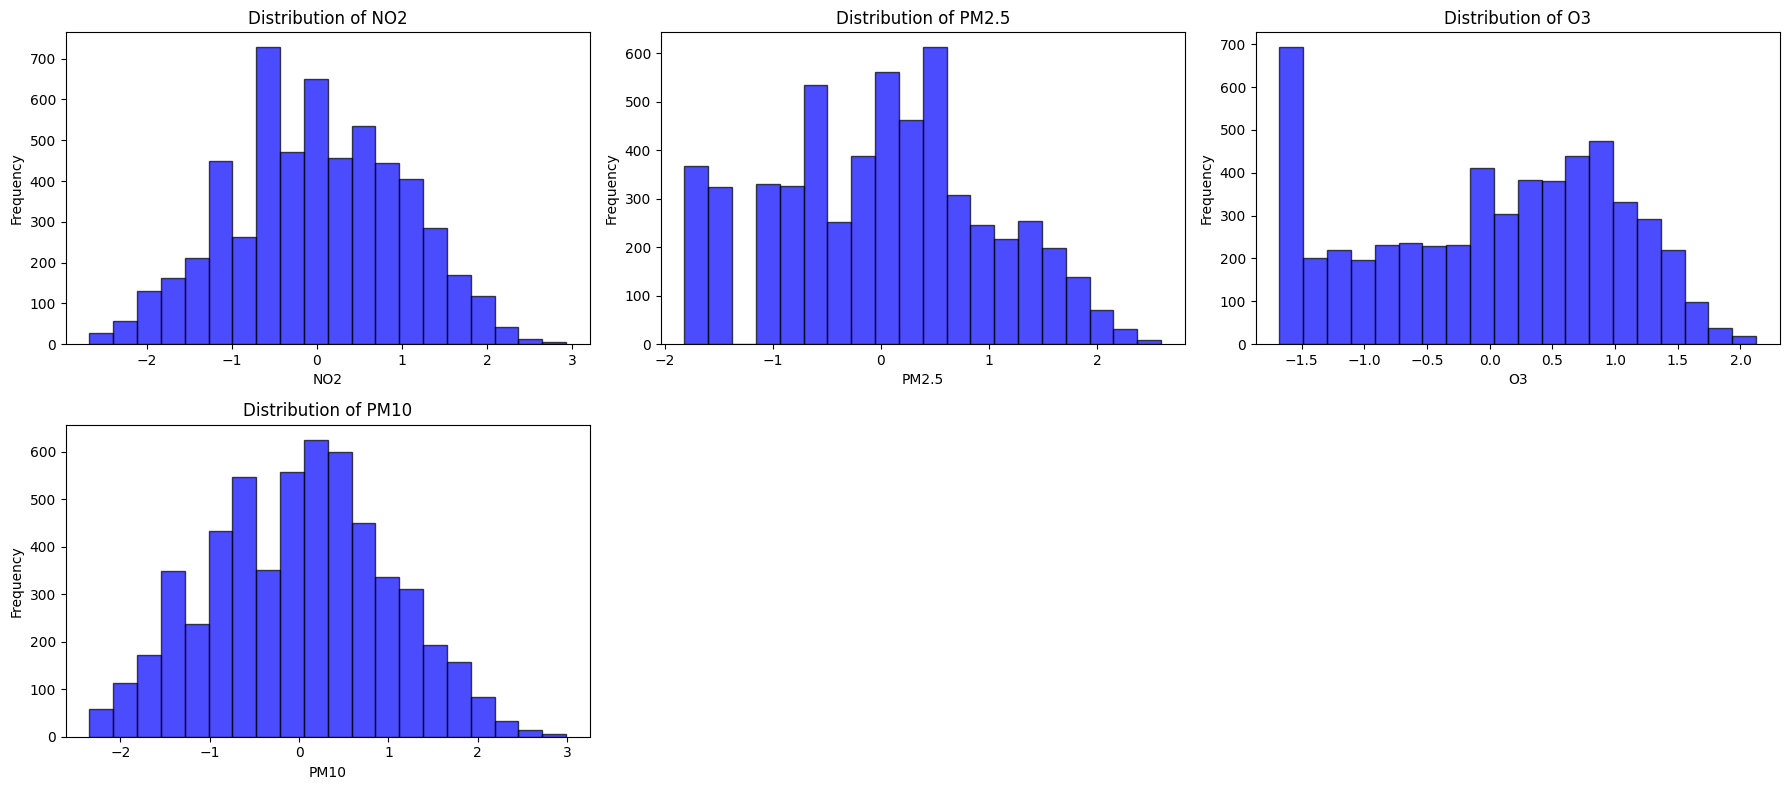

In [343]:
plot_distributions(df=df, ncols=3)

In [344]:
mms = MinMaxScaler()
std = StandardScaler()

df[['PM2.5', 'O3']] = mms.fit_transform(df[['PM2.5', 'O3']])
df[['NO2', 'PM10']] = std.fit_transform(df[['NO2', 'PM10']])

In [345]:
# 1. Lagged Features for NO2 (lag of 1 day)
df['lag1_NO2'] = df['NO2'].shift(1)

# 2. Rolling Window Statistics for PM10 (rolling mean over 7 days)
df['roll_mean_PM10_7d'] = df['PM10'].rolling(window=7).mean()

# 4. Change in PM2.5 from the previous measurement
df['diff_PM2.5'] = df['PM2.5'].diff()

# 5. Exponential Moving Average for O3 (span of 7 days)
df['ema_O3_7d'] = df['O3'].ewm(span=7, adjust=False).mean()

# 6. Cumulative Count of high NO2 days (above a certain threshold, e.g., 75th percentile)
threshold_NO2 = df['NO2'].quantile(0.75)
df['cum_count_high_NO2'] = (df['NO2'] > threshold_NO2).cumsum()

# 7. Interaction term between NO2 and O3
df['NO2_O3_interaction'] = df['NO2'] * df['O3']

# 8. Polynomial Feature (square of PM2.5)
df['PM2.5_squared'] = df['PM2.5'] ** 2

df['O3_quartile'] = pd.qcut(df['O3'], q=4, labels=False)

# 1. Rolling Variance of PM2.5 over a 7-day window
df['roll_var_PM2.5_7d'] = df['PM2.5'].rolling(window=7).var()

# 2. Peak-to-Peak Distance for NO2 over a 7-day window
df['ptp_NO2_7d'] = df['NO2'].rolling(window=7).apply(lambda x: np.ptp(x), raw=True)

# 3. Difference for PM10
df['diff_PM10'] = df['PM10'].diff()


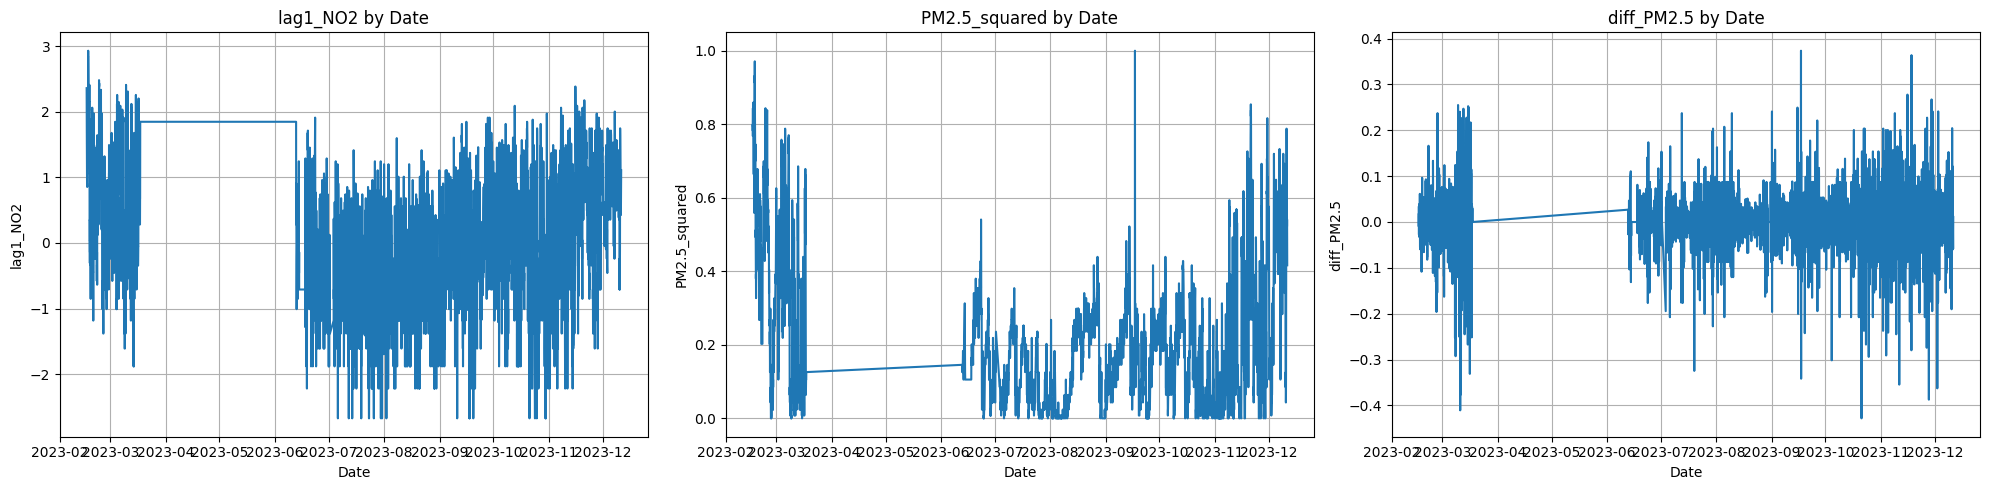

In [346]:
df[['lag1_NO2', 'PM2.5_squared', 'diff_PM2.5']].describe()
# Plot values of lagged features
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes = axes.flatten()
for i, column in enumerate(['lag1_NO2', 'PM2.5_squared', 'diff_PM2.5']):
    axes[i].plot(df.index, df[column])
    axes[i].set_title(f'{column} by Date')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

C:\Users\Tine Šuster\AppData\Local\Temp\ipykernel_9048\1110585169.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


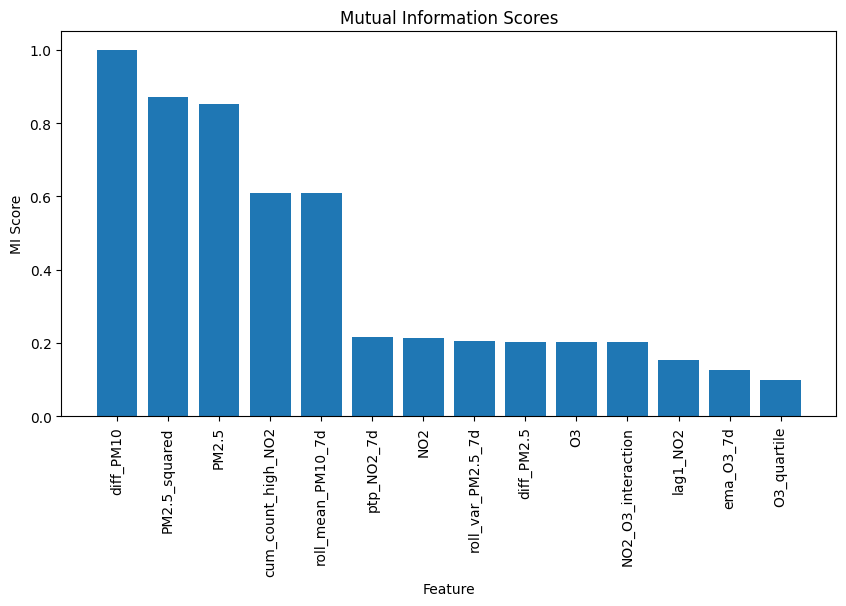

In [347]:
# TODO: REMOVE dropping NaN values
df.fillna(method='bfill', inplace=True)

X = df.drop(['PM10'], axis=1)
y = df['PM10']

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

mi_df = pd.DataFrame({'feature': X.columns, 'mi': mi}).sort_values(by='mi', ascending=False)
# plot the dataframe
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(mi_df['feature'], mi_df['mi'])
ax.set_title('Mutual Information Scores')
ax.set_xlabel('Feature')
ax.set_ylabel('MI Score')
plt.xticks(rotation=90)
plt.show()